# Regression Model Comparison using `PyCaret`

In [1]:
# !pip install pycaret # if necessary

In [2]:
import time
import numpy as np
import pandas as pd

import yfinance as yf

from pycaret.datasets import get_data
from pycaret.time_series import TSForecastingExperiment

### 1. Download IONQ data using `yfinance`

In [3]:
stockCode = "IONQ"
# startDate = "2022-07-01"
# endDate = "2023-06-30"

In [4]:
ticker = yf.Ticker(stockCode)
# price_hist = ticker.history(start=startDate, end=endDate)
price_hist = ticker.history(period="max", interval="1d")

price_hist.index = [x.date() for x in price_hist.index]
# date_range = pd.date_range(startDate, endDate)
# price_hist = price_hist.reindex(date_range)
price_hist.shape

(652, 7)

### 2. Add features
- Shift: Price before n days
- MA: Avg. price for last n days
- VolAvg: Avg. vol for last n days

In [5]:
close = price_hist[["Close", "Volume"]].copy()

close["Shift_1"] = close["Close"].shift(1)
close["Shift_5"] = close["Close"].shift(5)
close["Shift_20"] = close["Close"].shift(20)
close["Shift_60"] = close["Close"].shift(60)
close["Shift_120"] = close["Close"].shift(120)
close["Shift_240"] = close["Close"].shift(240)

close["MA_5"] = close["Close"].rolling(5).mean()
close["MA_20"] = close["Close"].rolling(20).mean()
close["MA_60"] = close["Close"].rolling(60).mean()
close["MA_120"] = close["Close"].rolling(120).mean()
close["MA_240"] = close["Close"].rolling(240).mean()

close["Vol_1"] = close["Volume"].shift(1)
close["VolAvg_5"] = close["Volume"].rolling(5).mean()
close["VolAvg_20"] = close["Volume"].rolling(20).mean()
close["VolAvg_60"] = close["Volume"].rolling(60).mean()
close["VolAvg_120"] = close["Volume"].rolling(120).mean()
close["VolAvg_240"] = close["Volume"].rolling(240).mean()

In [6]:
close = close.dropna()
print(close.shape)

(412, 19)


In [7]:
close.head(5)

,Close,Volume,Shift_1,Shift_5,Shift_20,Shift_60,Shift_120,Shift_240,MA_5,MA_20,MA_60,MA_120,MA_240,Vol_1,VolAvg_5,VolAvg_20,VolAvg_60,VolAvg_120,VolAvg_240
2021-12-15,17.840000,6809000,16.100000,20.969999,26.379999,10.05,10.39,10.80,17.558,22.1605,15.928500,13.006167,12.002708,5066300.0,5484760.0,8024910.0,6.950093e+06,3.746622e+06,2.182983e+06
2021-12-16,16.059999,7132400,17.840000,18.610001,31.000000,9.99,10.49,11.11,17.048,21.4135,16.029667,13.052583,12.023333,6809000.0,5658380.0,7365160.0,7.011992e+06,3.801465e+06,2.212012e+06
2021-12-17,16.770000,11570300,16.059999,18.570000,27.959999,10.01,10.55,11.05,16.688,20.8540,16.142333,13.104417,12.047167,7132400.0,7247060.0,6823755.0,7.136543e+06,3.895502e+06,2.259490e+06
2021-12-20,15.280000,5446000,16.770000,16.670000,28.010000,11.30,10.69,11.11,16.410,20.2175,16.208667,13.142667,12.064542,11570300.0,7204800.0,6682255.0,7.012695e+06,3.937217e+06,2.281790e+06
2021-12-21,16.180000,3845800,15.280000,16.100000,23.180000,11.94,10.70,11.01,16.426,19.8675,16.279333,13.188333,12.086083,5446000.0,6960700.0,6265540.0,6.910717e+06,3.967204e+06,2.297241e+06


In [8]:
close.tail(5)

,Close,Volume,Shift_1,Shift_5,Shift_20,Shift_60,Shift_120,Shift_240,MA_5,MA_20,MA_60,MA_120,MA_240,Vol_1,VolAvg_5,VolAvg_20,VolAvg_60,VolAvg_120,VolAvg_240
2023-08-01,19.860001,15524800,19.250000,15.220000,13.50,5.57,5.15,8.38,17.752,15.2575,11.543167,8.460000,6.719333,13950900.0,13164720.0,11035875.00,1.166753e+07,7.973620e+06,5.508369e+06
2023-08-02,18.330000,13988200,19.860001,16.190001,14.12,5.90,5.13,7.86,18.180,15.4680,11.750333,8.570000,6.762958,15524800.0,13958720.0,11041425.00,1.183181e+07,8.062512e+06,5.538263e+06
2023-08-03,18.290001,7780900,18.330000,15.530000,13.29,6.15,4.69,7.63,18.732,15.7180,11.952667,8.683333,6.807375,13988200.0,13212680.0,10921730.00,1.189428e+07,8.087948e+06,5.547073e+06
2023-08-04,17.389999,10830200,18.290001,17.930000,13.28,6.38,4.81,6.62,18.624,15.9235,12.136167,8.788167,6.852250,7780900.0,12415000.0,11046540.00,1.201259e+07,8.155308e+06,5.569294e+06
2023-08-07,15.220000,11223527,17.389999,19.250000,14.03,6.95,4.89,6.42,17.818,15.9830,12.274000,8.874250,6.888917,10830200.0,11869525.4,11136876.35,1.211144e+07,8.227821e+06,5.601843e+06


### 3. EDA

In [9]:
close = close.drop(columns=["Volume"])
print(close.shape)

(412, 18)


In [11]:
# We want to forecast the next 12 months of data and we will use 3 fold cross-validation to test the models.
fh = 12 # or alternately fh = np.arange(1,13)
fold = 3

In [12]:
# Global Figure Settings for notebook ----
# Depending on whether you are using jupyter notebook, jupyter lab, Google Colab, you may have to set the renderer appropriately
# NOTE: Setting to a static renderer here so that the notebook saved size is reduced.
fig_kwargs = {
    # "renderer": "notebook",
    "renderer": "png",
    "width": 1000,
    "height": 600,
}

In [13]:
close["index"] = range(close.shape[0])

In [14]:
close.dtypes

Close         float64
Shift_1       float64
Shift_5       float64
Shift_20      float64
Shift_60      float64
Shift_120     float64
Shift_240     float64
MA_5          float64
MA_20         float64
MA_60         float64
MA_120        float64
MA_240        float64
Vol_1         float64
VolAvg_5      float64
VolAvg_20     float64
VolAvg_60     float64
VolAvg_120    float64
VolAvg_240    float64
index           int64
dtype: object

In [15]:
eda = TSForecastingExperiment()
eda.setup(
        data=close, 
        session_id = 123,
        index = "index",
        target="Close", 
        numeric_imputation_target="ffill",
        numeric_imputation_exogenous="ffill",
        fh=fh, 
        fig_kwargs=fig_kwargs)

,Description,Value
0,session_id,123
1,Target,Close
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(412, 18)"
5,Transformed data shape,"(412, 18)"
6,Transformed train set shape,"(400, 18)"
7,Transformed test set shape,"(12, 18)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


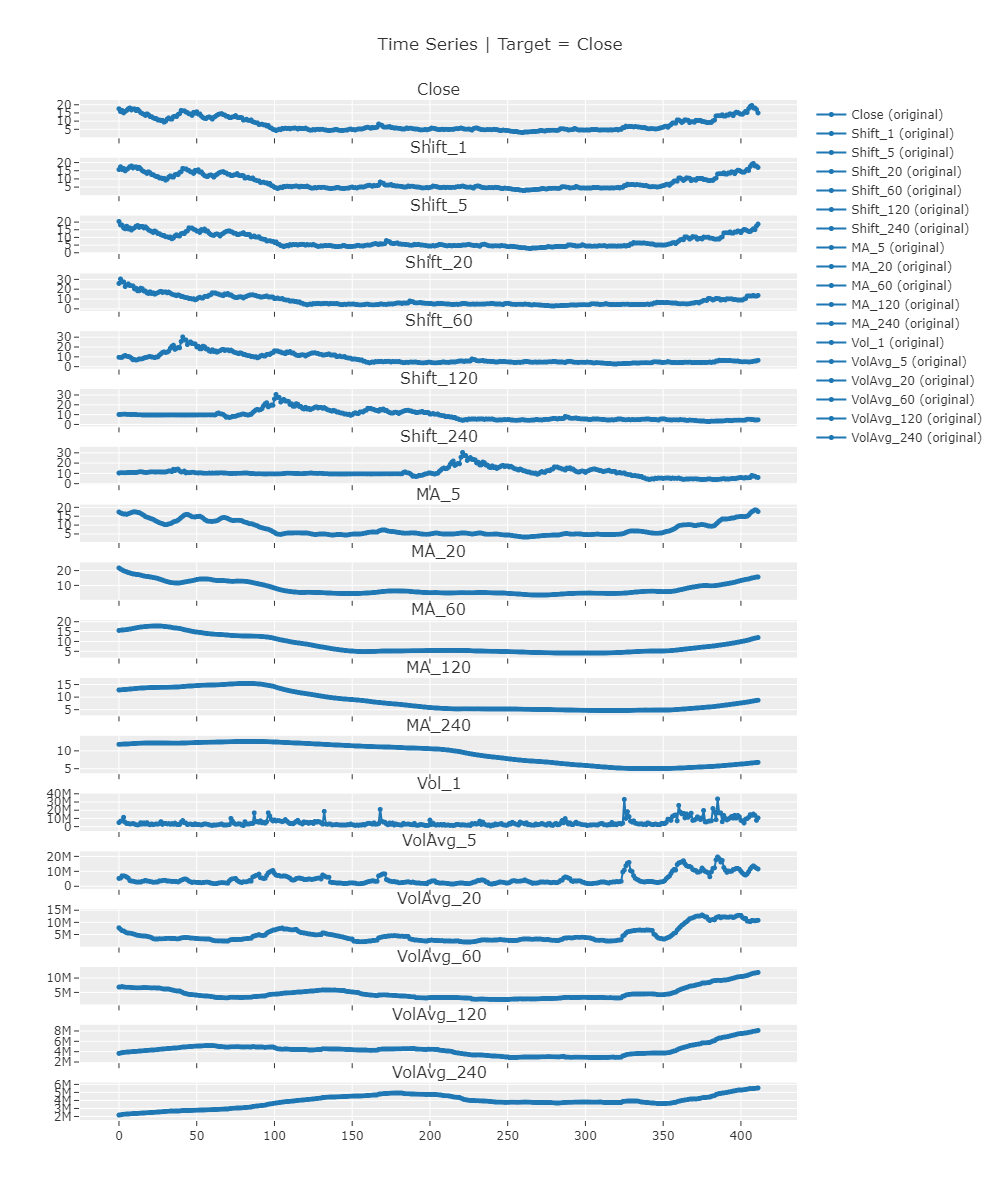

In [16]:
# Plot the target variable along with any exogenous variables ----
# Becasue the data is quite huge, plotting an interactive plot can slow down the notebook.
# Hence, we will revert to a static renderer for this plot
eda.plot_model(fig_kwargs={"renderer": "png", "width": 1000, "height": 1200})

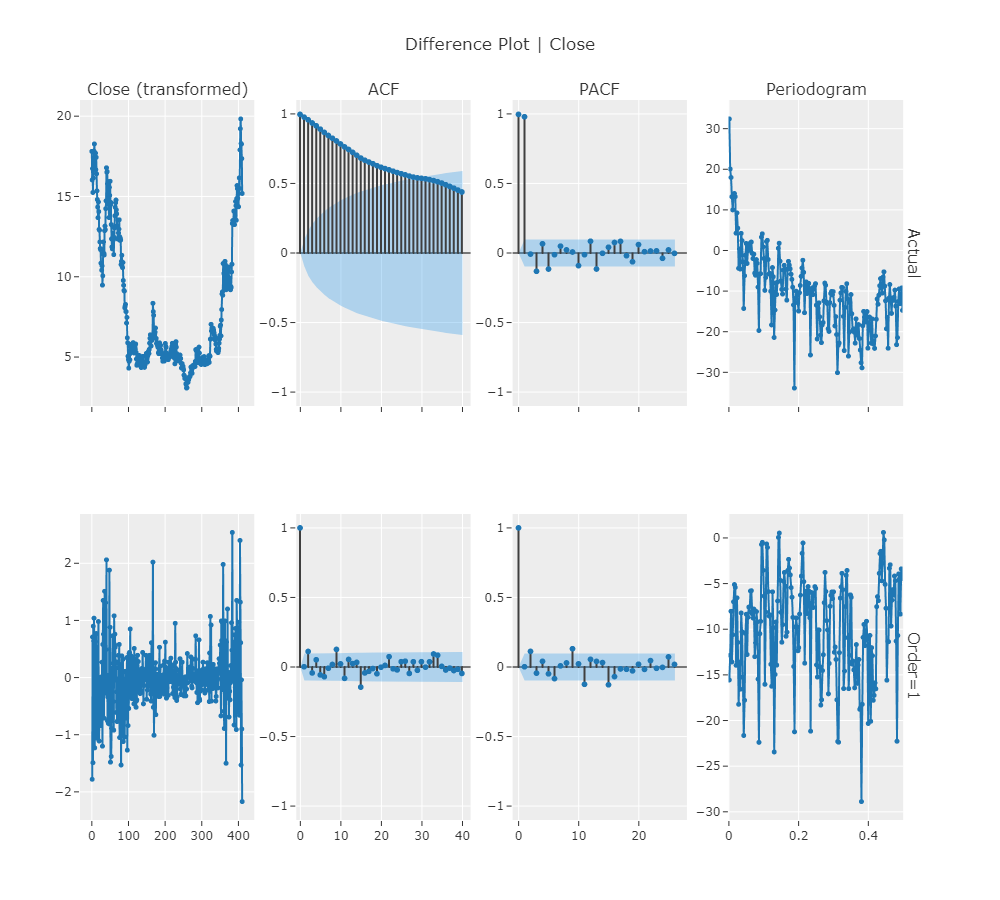

In [18]:
# Plots original data with first difference (order d = 1) by default
# NOTE: Uncomment out display_format to use "plotly-widget".
eda.plot_model(
    plot="diff",
    fig_kwargs={
        "height": 900,
        # No need to pass show_dash kwargs when using a plotly-widget
        "resampler_kwargs": {"default_n_shown_samples": 1500 }
    },
    data_kwargs={"acf": True, "pacf": True, "periodogram": True},
    # display_format="plotly-widget",
)

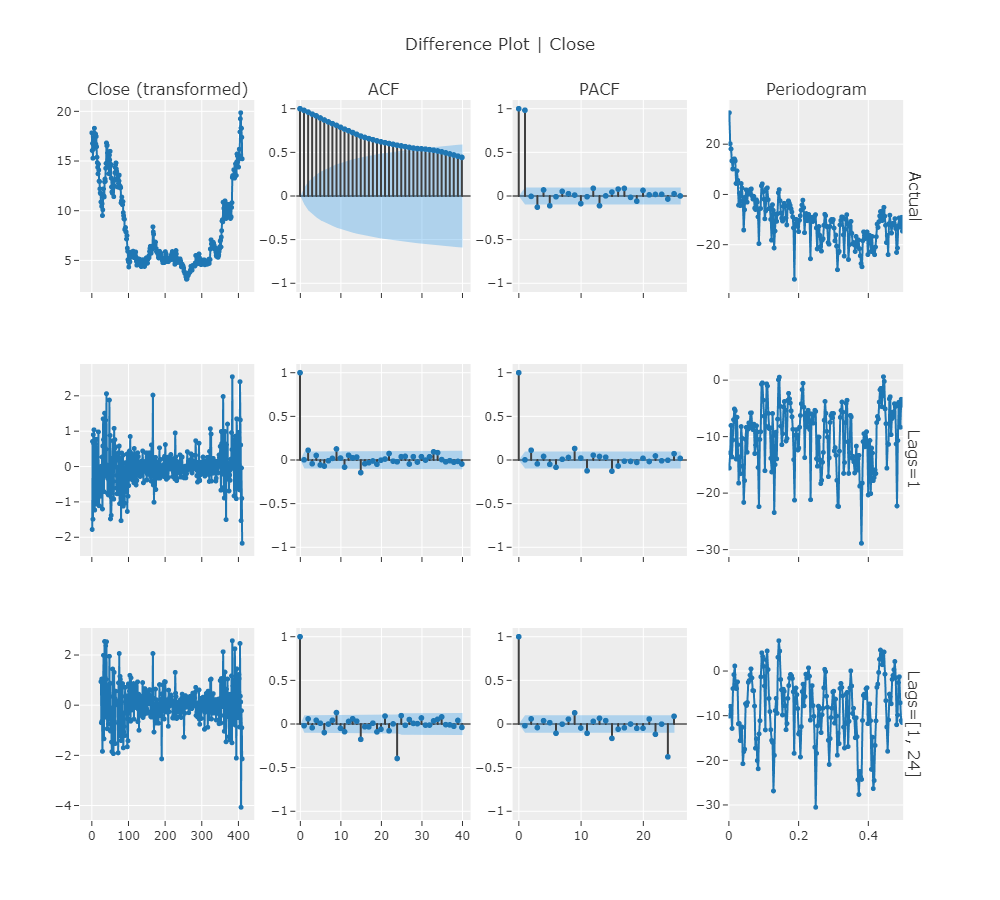

In [19]:
eda.plot_model(
    plot="diff",
    fig_kwargs={
        "height": 900,
        "resampler_kwargs": {
            "default_n_shown_samples": 1500,
            "show_dash": {"mode": "inline", "port": 8056},
        },
    },
    data_kwargs={
        "lags_list": [1, [1, 24]],
        "acf": True,
        "pacf": True,
        "periodogram": True,
    },
    # display_format='plotly-dash',
)

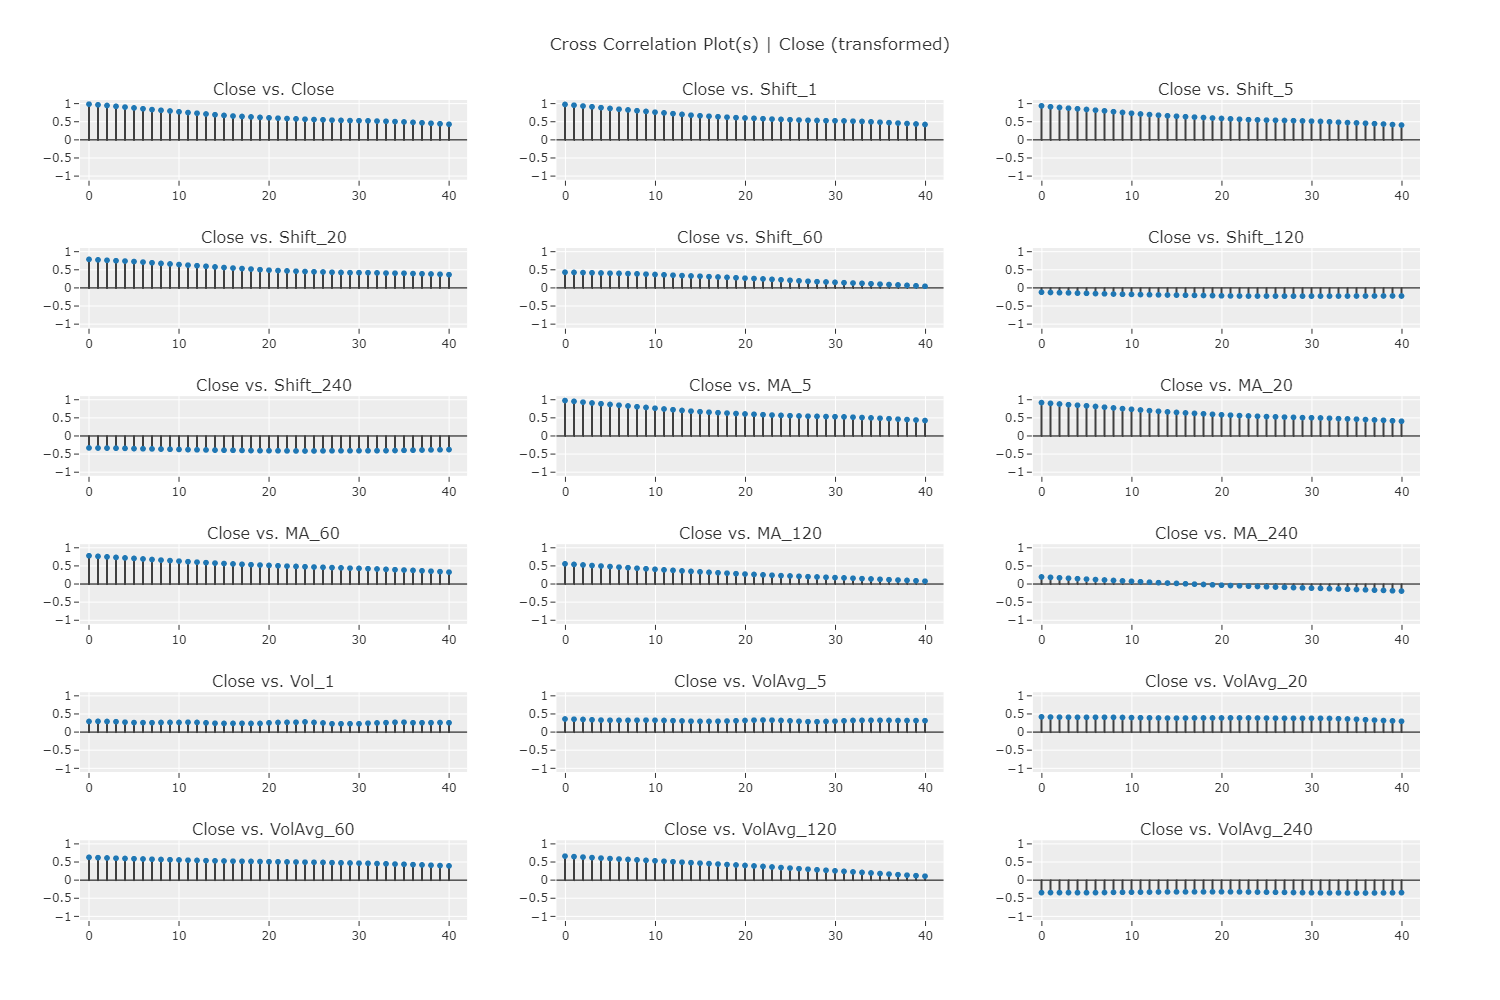

In [21]:
# Cross correlation plots
eda.plot_model(plot="ccf", fig_kwargs={"height": 1000, "width": 1500})